In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate, Dropout
from tensorflow.keras import Input, Model
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re

In [4]:

import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [5]:

max_eng_len = 34
max_mar_len = 37
ENG_VOCAB_SIZE = 5836
MAR_VOCAB_SIZE = 14386

In [6]:
# Encoder

encoder_inputs = Input(shape=(max_eng_len,))
enc_emb = Embedding(ENG_VOCAB_SIZE, 1024)(encoder_inputs)

# Bidirectional lstm layer
enc_lstm1 = Bidirectional(LSTM(256,return_sequences=True,return_state=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = enc_lstm1(enc_emb)

final_enc_h = Concatenate()([forw_state_h,back_state_h])
final_enc_c = Concatenate()([forw_state_c,back_state_c])

encoder_states =[final_enc_h, final_enc_c]

# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(MAR_VOCAB_SIZE, 1024)
dec_emb = dec_emb_layer(decoder_inputs)
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(512, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

#Attention Layer
attention_layer = AttentionLayer(name="attension_layer")
attention_result, attention_weights = attention_layer([encoder_outputs1, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

#Dense layer
decoder_dense = Dense(MAR_VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 1024)             5976064   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 34, 512),            2623488   ['embedding[0][0]']           
 al)                          (None, 256),                                                    

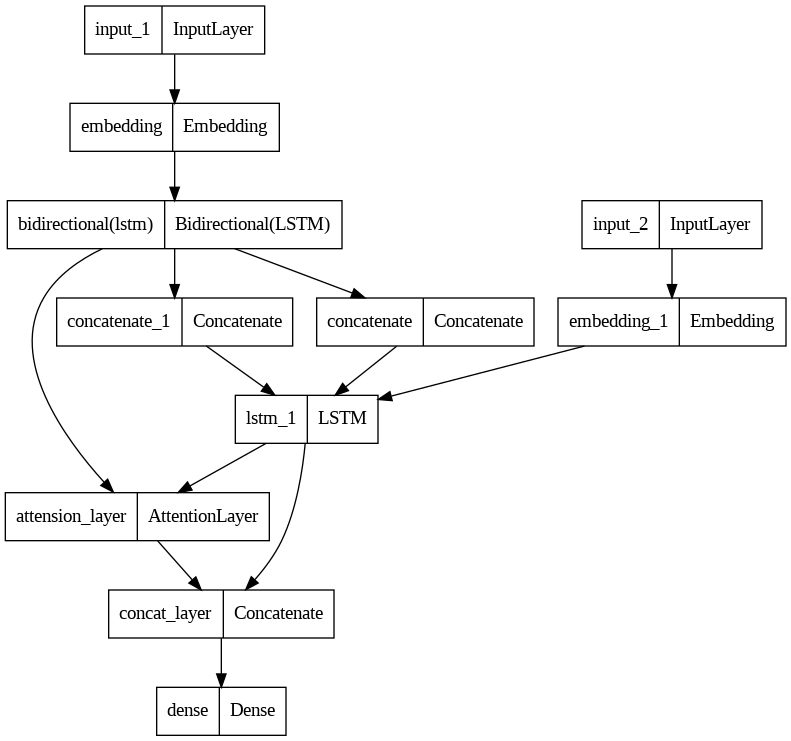

In [8]:
from keras.utils import plot_model
plot_model(model)

In [9]:
model.load_weights("/content/drive/MyDrive/deep_learning_projects/Neural_machine_transaltion/attention/weights/model_main/model_main.h5")

### Inference Model

In [10]:
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

decoder_state_h = Input(shape=(512,))
decoder_state_c = Input(shape=(512,))
decoder_hidden_state_input = Input(shape=(34,512))

dec_states = [decoder_state_h, decoder_state_c]

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

# Attention inference
attention_result_inf, attention_weights_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])

decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

dec_states2= [state_h2, state_c2]

decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

decoder_model= Model(
                    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

In [11]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = mar_word_index['sos']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
            # convert max index number to marathi word
            sampled_char = mar_index_word[sampled_token_index]

        if (sampled_char!='end'):
            # aapend it ti decoded sent
            decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence.split()) >= 36):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update states
        enc_h, enc_c = h, c

    return decoded_sentence

In [12]:

import pickle

mar_index_word=dict()
with open('/content/drive/MyDrive/deep_learning_projects/Neural_machine_transaltion/attention/working_dir_data/mar_index_word.pkl', 'rb') as f:
  mar_index_word = pickle.load(f)

eng_index_word=dict()
with open('/content/drive/MyDrive/deep_learning_projects/Neural_machine_transaltion/attention/working_dir_data/eng_index_word.pkl', 'rb') as f:
  eng_index_word = pickle.load(f)

eng_word_indec = dict()
with open("/content/drive/MyDrive/deep_learning_projects/Neural_machine_transaltion/attention/working_dir_data/eng_word_indec.pkl", "rb") as f:
  eng_word_indec = pickle.load(f)

mar_word_index = dict()
with open("/content/drive/MyDrive/deep_learning_projects/Neural_machine_transaltion/attention/working_dir_data/mar_word_index.pkl", "rb") as f:
  mar_word_index = pickle.load(f)

In [13]:
with open("/content/drive/MyDrive/deep_learning_projects/Neural_machine_transaltion/attention/working_dir_data/contraction_expansion.txt", 'rb') as fp:
    contractions= pickle.load(fp)


In [14]:

def expand_contras(text):
    '''
    takes input as word or list of words
    if it is string and contracted it will expand it
    example:
    it's --> it is
    won't --> would not
    '''
    if type(text) is str:
        for key in contractions:
            value = contractions[key]
            text = text.replace(key, value)
        return text
    else:
        return text


In [15]:
def get_marathi_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0 :
        sentence =sentence +mar_index_word[i]+' '
    return sentence

def get_english_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0:
        sentence =sentence +eng_index_word[i]+' '
    return sentence

In [16]:
eng_texts = "Tom isn't not talking to me"
eng_texts_2 = "go"

In [17]:
eng_texts_2 = eng_texts_2.lower()

eng_texts_2 = expand_contras(eng_texts_2)
print(eng_texts_2)

go


In [18]:
eng_texts_2 = eng_texts_2.split()
print(eng_texts_2)

['go']


In [19]:
# eng_texts =np.array(eng_texts)
# print(eng_texts)

In [20]:
# loading tokenizer
with open('/content/drive/MyDrive/deep_learning_projects/Neural_machine_transaltion/attention/working_dir_data/eng_tokenizer.pkl', 'rb') as f:
    eng_tokenizer = pickle.load(f)

In [21]:
len(eng_tokenizer.word_counts)

5835

In [22]:
input_sequence = eng_tokenizer.texts_to_sequences(eng_texts_2)
input_sequence

[[37]]

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
eng_padded = pad_sequences(input_sequence, maxlen=34
                           , padding='post')

In [24]:
eng_padded

array([[37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]], dtype=int32)

In [25]:
eng_padded = np.array(eng_padded)
eng_padded

array([[37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]], dtype=int32)

In [26]:
get_english_sentence([37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0])

'go '

In [27]:
get_predicted_sentence(eng_padded)

1/1 [==============================] - 0s 22ms/step


' जा eos'

In [38]:

def english_preprocessing(data, col):
    data[col] = data[col].astype(str)
    data[col] = data[col].apply(lambda x: x.lower())
    data[col] = data[col].apply(lambda x: re.sub("[^A-Za-z\s]","",x))   # all non-alphabetic characters

    data[col] = data[col].apply(lambda x: x.replace("\s+"," "))  # adjust multiple spaces
    data[col] = data[col].apply(lambda x: " ".join([word for word in x.split()]))

    return data

In [56]:
# eng_texts = "Tom isn't not talking to me"
# eng_texts_2 = "Tom isn't     talking to me"     # "go"

eng_texts_2 = " I am the lion"

df = pd.DataFrame()

df["English"] = [ eng_texts_2 ]
print(df)

df = english_preprocessing(df, "English")

## Unveiling the contractions in English
df.English = df.English.apply(lambda x: expand_contras(x))

eng_texts_2 = df.English.to_list()
print(eng_texts_2)

eng_encoded = eng_tokenizer.texts_to_sequences(eng_texts_2)
print(eng_encoded)


eng_padded = pad_sequences(eng_encoded, maxlen=34
                           , padding='post')
print(eng_padded)

a = get_predicted_sentence(eng_padded)


# eng_texts_2 = eng_texts_2.lower()

# eng_texts_2 = expand_contras(eng_texts_2)
# print(eng_texts_2)

          English
0   I am the lion
['i am the lion']
[[2, 140, 4, 1811]]
[[   2  140    4 1811    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
1/1 [==============================] - 0s 68ms/step


In [57]:
print(a)

 मी सिंह आहे eos
